In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import cufflinks as cf
import plotly.graph_objs as go
from plotly.plotly import iplot

import re
import string

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

from textblob import TextBlob

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, classification_report

# Downloading the dictionaries directly from the nltk website. (Specifically, you'll need to download the stopwords dictionary, punkt tokenizer models, and wordnet dictionary.)
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')


In [31]:
tweet= pd.read_csv('bitcoin-tweets.csv')

In [3]:
tweet.head()

,Unnamed: 0,created,text,retweets,favourites,verified,hashtags,user_id,user_location,user_followers
0,0,2019-08-09 10:47:06,Get Goals so Big that you can’t Achieve it unt...,0,0,False,"[{'text': 'FinxStores', 'indices': [85, 96]}, ...",996798243345453062,Nigeria,243
1,1,2019-08-09 10:47:05,RT @BeatzCoin: Censorship Resistant\n\nCreator...,22,0,False,[],2495841841,888,8337
2,2,2019-08-09 10:47:03,RT @gold_stellar: Private sale is ongoing if y...,5213,0,False,"[{'text': 'stellargold', 'indices': [127, 139]}]",1158645871711420416,NaN,0
3,3,2019-08-09 10:47:01,RT @Changelly_team: Changelly fee lowered to 0...,9,0,False,[],996825396451659778,NaN,304
4,4,2019-08-09 10:46:53,✅Receive Faster BTKuCoin Done Success\n✅Time A...,0,0,False,[],1136512132747603969,NaN,2362


In [4]:
# As we are interested only in the text we create a new dataframe contaiing text
tweets = tweet[['created','text']]

In [5]:
tweets.head()

,created,text
0,2019-08-09 10:47:06,Get Goals so Big that you can’t Achieve it unt...
1,2019-08-09 10:47:05,RT @BeatzCoin: Censorship Resistant\n\nCreator...
2,2019-08-09 10:47:03,RT @gold_stellar: Private sale is ongoing if y...
3,2019-08-09 10:47:01,RT @Changelly_team: Changelly fee lowered to 0...
4,2019-08-09 10:46:53,✅Receive Faster BTKuCoin Done Success\n✅Time A...


In [6]:
sample = 'This is the pre-processing stages    @ApplE. #whataday This is SOOOO EXCI~TING. Cows. Thats all i have to say'

In [7]:
# word_tokenize - transforms our string/text into a list of words (separated by a white space), where each word is 
# called a token.
word_tokenize(sample)

['This',
 'is',
 'the',
 'pre-processing',
 'stages',
 '@',
 'ApplE',
 '.',
 '#',
 'whataday',
 'This',
 'is',
 'SOOOO',
 'EXCI~TING',
 '.',
 'Cows',
 '.',
 'Thats',
 'all',
 'i',
 'have',
 'to',
 'say']

In [8]:
def clean_text(sample_text):
    
    # Given a sample text (as a string), we first substitute a select few sybmols with white space
    sample_text = re.sub(r'[#|@|-|?|!]',r' ',sample_text)
    
    # We then strip extra white space
    sample_text = re.sub('\s+',' ', sample_text)
    
    # Then change everything to lower case
    sample_text = sample_text.lower()
    
    # Then lemmatize our words -- note,  stemming was deemed too crude here, and therefore not chosen
    sample_text = WordNetLemmatizer().lemmatize(sample_text)
    
    
    # Now that we transformed our text, we need to tokenize it. Let's treat each word as a token.
    words = word_tokenize(sample_text)
    
    # As we now have a list of words,  we can go ahead and find and remove those words that also belong to the 
    # stopwords list from the NLTK corpus
    words = [w for w in words if w not in stopwords.words('english')]
    
    # We then proceed to joining those list of words, back to 'free text'  or string format
    text = ' '.join(words)
    
    return text

In [9]:
# We can quickly apply the above function by using the 'apply' and 'lambda' functions as so
tweets = tweets['text'].apply(lambda x: clean_text(x))

# Let's see the results!
tweets

0        get goals big ’ achieve grow person . 🙏 finxst...
1        rt beatzcoin : censorship resistant creators a...
2        rt gold_stellar : private sale ongoing guys wa...
3        rt changelly_team : changelly fee lowered 0,25...
4        ✅receive faster btkucoin done success ✅time au...
5        rt cryptovanessa : newprofilpic neuesprofilbil...
6        rt calvinayre : fans alt coins ( including btc...
7        tiny bank gave bitcoin entire staff . ‘ taking...
8        prices update $ usdt every 1 hour : $ rdd - 0....
9        rt gold_stellar : private sale ongoing guys wa...
10       btcusd open long 11774 4 unit , sold 11730 , p...
11       rt hitfinex : . blockchainnote listed hitfinex...
12       rt alphabetalgebra : crypto-friendly banks ext...
13                               move incoming 4hr bitcoin
14       rt safari_kenyan : come live every day 1330hrs...
15       pickle_crypto alistairmilne petermccormack yes...
16       aigopay aigo perfect platform every investor w.

In [10]:
tweets.head()

0    get goals big ’ achieve grow person . 🙏 finxst...
1    rt beatzcoin : censorship resistant creators a...
2    rt gold_stellar : private sale ongoing guys wa...
3    rt changelly_team : changelly fee lowered 0,25...
4    ✅receive faster btkucoin done success ✅time au...
Name: text, dtype: object

In [11]:

# We specify that we need no more than 10000 features -- i.e. 1000 unique terms. Of course, this is an arbitrary number
# feel free to play around with this parameter!

# We also specify the min_df parameter to be 0.01. This means that our terms should at least be used in 1% of our 
# tweets.

# Finally, we specify an ngram_range of 1. This means that we're only looking for words -- an ngram_range of (1,2) 
# would include both words (length = 1) and phrases or combinations of words of length = 2 
vector = CountVectorizer(max_features= 10000 , min_df=0.01, ngram_range= (1,1))

# We use the fit_transform() function to apply the above to our tweets
bag_of_words = vector.fit_transform(tweets)

bag_of_words

<20008x171 sparse matrix of type '<class 'numpy.int64'>'
	with 122127 stored elements in Compressed Sparse Row format>

In [12]:
# Let's get our terms
vector.get_feature_names()

['000',
 '08',
 '09',
 '10',
 '100',
 '11',
 '12',
 '20',
 '2019',
 '50',
 '500',
 'ai',
 'airdrop',
 'alert',
 'ama',
 'amp',
 'antpool',
 'apompliano',
 'askmeanythi',
 'august',
 'away',
 'axe',
 'axerunners',
 'back',
 'based',
 'best',
 'binance',
 'bitcoin',
 'blockchain',
 'blockstream',
 'bonus',
 'btc',
 'buy',
 'cd9ispfl2t',
 'celebrate',
 'check',
 'class',
 'co',
 'colocation',
 'coming',
 'comme',
 'comment',
 'community',
 'crypto',
 'cryptochaseio',
 'cryptocurrencies',
 'cryptocurrency',
 'daily',
 'day',
 'days',
 'digital',
 'discord',
 'droids',
 'earn',
 'enter',
 'enterprise',
 'equipment',
 'eth',
 'ethereum',
 'every',
 'everyone',
 'exchange',
 'excited',
 'first',
 'follow',
 'free',
 'friends',
 'future',
 'game',
 'get',
 'giveaway',
 'giving',
 'going',
 'gold',
 'gold_stellar',
 'good',
 'got',
 'great',
 'group',
 'guys',
 'happening',
 'hitfinex',
 'hour',
 'hours',
 'https',
 'huobi',
 'huobiprime',
 'ico',
 'investment',
 'iost',
 'join',
 'know',
 'las

In [17]:
# Find the sum of occurences of each term
sum_of_words = bag_of_words.sum(axis= 0)

# Create a list of tuples where each element represents the term in question and how many times it occurs in our 
# corpus.
words_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]

# Sort in decreasing order of frequency.
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

words_freq

[('https', 12299),
 ('rt', 12227),
 ('co', 12210),
 ('bitcoin', 7890),
 ('crypto', 5028),
 ('btc', 3229),
 ('blockchain', 2127),
 ('follow', 1928),
 ('retweet', 1742),
 ('amp', 1475),
 ('like', 1472),
 ('cryptocurrency', 1368),
 ('giveaway', 1353),
 ('000', 1242),
 ('buy', 1179),
 ('exchange', 1119),
 ('hitfinex', 1070),
 ('trading', 1060),
 ('xrp', 1048),
 ('get', 995),
 ('new', 956),
 ('join', 935),
 ('eth', 905),
 ('guys', 810),
 ('today', 800),
 ('away', 792),
 ('want', 774),
 ('make', 766),
 ('2019', 758),
 ('50', 753),
 ('token', 749),
 ('price', 744),
 ('mining', 730),
 ('ethereum', 721),
 ('time', 714),
 ('giving', 711),
 ('xlmg', 707),
 ('start', 707),
 ('listed', 706),
 ('sale', 700),
 ('bonus', 695),
 ('money', 684),
 ('telegram', 678),
 ('win', 658),
 ('gold_stellar', 652),
 ('stellargold', 644),
 ('group', 631),
 ('blockstream', 616),
 ('participate', 614),
 ('private', 613),
 ('08', 612),
 ('free', 580),
 ('ongoing', 578),
 ('enter', 561),
 ('one', 555),
 ('us', 529),
 ('

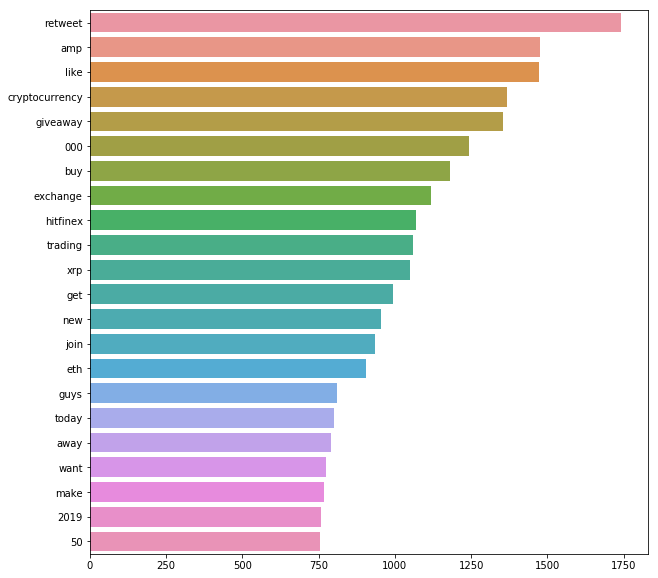

In [18]:
# Ignoring top word (which is "https", rt, co, bitocoin, cryoti, btc, blockchain in this case)
top_words = words_freq[8:30]

word = []
count = []

for i, j in top_words: 
    word.append(i)
    count.append(j)

# Asjusting figure size
plt.figure(figsize = (10,10))

# Plotting a barplot of most frequent words using Seaborn
sns.barplot(x = count, y = word)

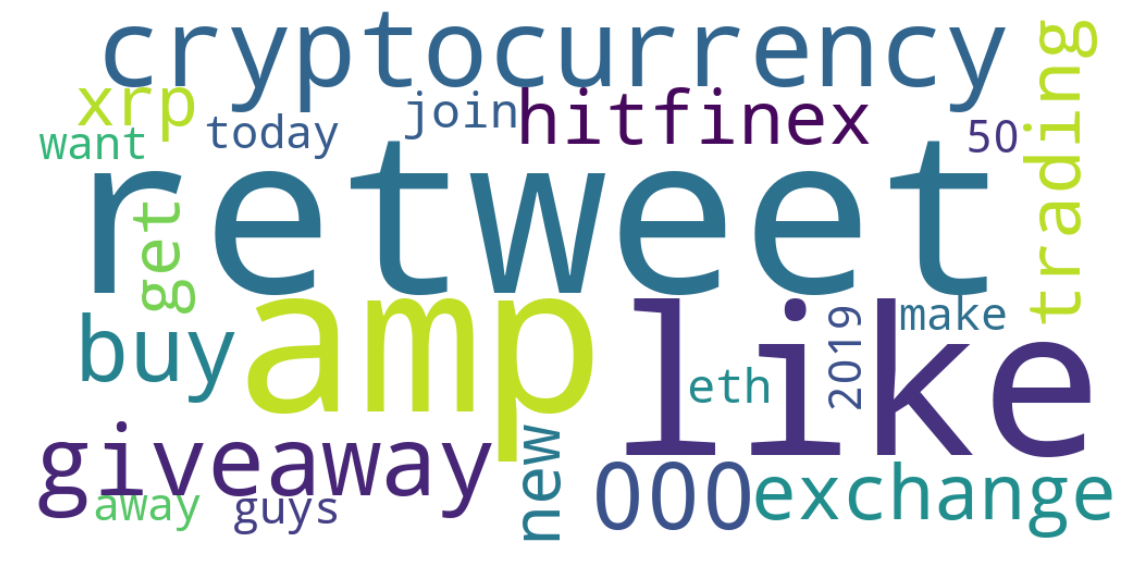

In [19]:
# Another way to plot most frequent words is through use of Wordclouds
words_dict = {}
for k,v in top_words:
    words_dict[k] = int(v)

# Using the WordCloud library
wordcloud = WordCloud(width=1000, height=500, background_color="white").generate_from_frequencies(words_dict)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [20]:
top_words

[('retweet', 1742),
 ('amp', 1475),
 ('like', 1472),
 ('cryptocurrency', 1368),
 ('giveaway', 1353),
 ('000', 1242),
 ('buy', 1179),
 ('exchange', 1119),
 ('hitfinex', 1070),
 ('trading', 1060),
 ('xrp', 1048),
 ('get', 995),
 ('new', 956),
 ('join', 935),
 ('eth', 905),
 ('guys', 810),
 ('today', 800),
 ('away', 792),
 ('want', 774),
 ('make', 766),
 ('2019', 758),
 ('50', 753)]

### Sentiment Analysis

In [21]:

# We create a list of sentiment scores on each of our tweets using Textblob
sentiments = []

for tweet in tweets:
    analysis = TextBlob(tweet)
    sentiments.append(analysis.sentiment.polarity)

# We add that list to a new dataframe of our tweets
tweets_df = pd.DataFrame(tweets)

tweets_df['sentiments'] = sentiments

tweets_df

,text,sentiments
0,get goals big ’ achieve grow person . 🙏 finxst...,0.000000
1,rt beatzcoin : censorship resistant creators a...,0.100000
2,rt gold_stellar : private sale ongoing guys wa...,0.000000
3,"rt changelly_team : changelly fee lowered 0,25...",0.800000
4,✅receive faster btkucoin done success ✅time au...,0.300000
5,rt cryptovanessa : newprofilpic neuesprofilbil...,0.800000
6,rt calvinayre : fans alt coins ( including btc...,0.200000
7,tiny bank gave bitcoin entire staff . ‘ taking...,0.000000
8,prices update $ usdt every 1 hour : $ rdd - 0....,0.000000
9,rt gold_stellar : private sale ongoing guys wa...,0.000000


In [22]:
tweets_df.head()

,text,sentiments
0,get goals big ’ achieve grow person . 🙏 finxst...,0.0
1,rt beatzcoin : censorship resistant creators a...,0.1
2,rt gold_stellar : private sale ongoing guys wa...,0.0
3,"rt changelly_team : changelly fee lowered 0,25...",0.8
4,✅receive faster btkucoin done success ✅time au...,0.3


In [23]:
tweets.head()

0    get goals big ’ achieve grow person . 🙏 finxst...
1    rt beatzcoin : censorship resistant creators a...
2    rt gold_stellar : private sale ongoing guys wa...
3    rt changelly_team : changelly fee lowered 0,25...
4    ✅receive faster btkucoin done success ✅time au...
Name: text, dtype: object

In [24]:
# find most positive tweets
positive = tweets_df.sort_values(by = 'sentiments', ascending=False)
positive = positive.reset_index(drop=True)


# find most negative tweets
negative = tweets_df.sort_values(by='sentiments', ascending=True)
negative = negative.reset_index(drop=True)

print(negative)

                                                    text  sentiments
0      rt ronniemoas : take anything peterschiff says...        -1.0
1      rt bucephalusdev : freud ’ onnarcissism fiat $...        -1.0
2      rt ronniemoas : take anything peterschiff says...        -1.0
3      bitcoin 's macro outlook grim ; analyst says 2...        -1.0
4      couple boring days media started headlines `` ...        -1.0
5      rt jimmyzhong_iost : $ btc monthly chart looks...        -1.0
6      rt ronniemoas : take anything peterschiff says...        -1.0
7      rt ronniemoas : take anything peterschiff says...        -1.0
8      rt ronniemoas : take anything peterschiff says...        -1.0
9      bitcoin merchant adoption - bleak state affair...        -1.0
10     bitcoin crypto blockchain scam remember funnie...        -1.0
11     rt ronniemoas : take anything peterschiff says...        -1.0
12     evil bitcoin ransomware ’ return data – even p...        -1.0
13     worst license plate ever ..

In [25]:
tweets_df.head()

,text,sentiments
0,get goals big ’ achieve grow person . 🙏 finxst...,0.0
1,rt beatzcoin : censorship resistant creators a...,0.1
2,rt gold_stellar : private sale ongoing guys wa...,0.0
3,"rt changelly_team : changelly fee lowered 0,25...",0.8
4,✅receive faster btkucoin done success ✅time au...,0.3


In [26]:
tweets.head()

0    get goals big ’ achieve grow person . 🙏 finxst...
1    rt beatzcoin : censorship resistant creators a...
2    rt gold_stellar : private sale ongoing guys wa...
3    rt changelly_team : changelly fee lowered 0,25...
4    ✅receive faster btkucoin done success ✅time au...
Name: text, dtype: object

In [32]:
tweet['sentiments'] =tweets_df.sentiments

In [33]:
tweet.head()

,Unnamed: 0,created,text,retweets,favourites,verified,hashtags,user_id,user_location,user_followers,sentiments
0,0,2019-08-09 10:47:06,Get Goals so Big that you can’t Achieve it unt...,0,0,False,"[{'text': 'FinxStores', 'indices': [85, 96]}, ...",996798243345453062,Nigeria,243,0.0
1,1,2019-08-09 10:47:05,RT @BeatzCoin: Censorship Resistant\n\nCreator...,22,0,False,[],2495841841,888,8337,0.1
2,2,2019-08-09 10:47:03,RT @gold_stellar: Private sale is ongoing if y...,5213,0,False,"[{'text': 'stellargold', 'indices': [127, 139]}]",1158645871711420416,NaN,0,0.0
3,3,2019-08-09 10:47:01,RT @Changelly_team: Changelly fee lowered to 0...,9,0,False,[],996825396451659778,NaN,304,0.8
4,4,2019-08-09 10:46:53,✅Receive Faster BTKuCoin Done Success\n✅Time A...,0,0,False,[],1136512132747603969,NaN,2362,0.3


In [34]:
tweet_final= tweet[['sentiments', 'created']]

In [35]:
tweet_final.head()

,sentiments,created
0,0.0,2019-08-09 10:47:06
1,0.1,2019-08-09 10:47:05
2,0.0,2019-08-09 10:47:03
3,0.8,2019-08-09 10:47:01
4,0.3,2019-08-09 10:46:53


In [36]:
tweet_final['created']=  pd.to_datetime(tweet_final['created'])

In [37]:
tweet_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20008 entries, 0 to 20007
Data columns (total 2 columns):
sentiments    20008 non-null float64
created       20008 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 312.7 KB


In [38]:
tweet_final['date_hour']=tweet_final['created'].apply(lambda x: x.round('H'))


In [40]:
tweet_final.head()

,sentiments,created,date_hour
0,0.0,2019-08-09 10:47:06,2019-08-09 11:00:00
1,0.1,2019-08-09 10:47:05,2019-08-09 11:00:00
2,0.0,2019-08-09 10:47:03,2019-08-09 11:00:00
3,0.8,2019-08-09 10:47:01,2019-08-09 11:00:00
4,0.3,2019-08-09 10:46:53,2019-08-09 11:00:00


In [41]:

tweet_groupbyhr=tweet_final.groupby(['date_hour'], as_index=False)['sentiments'].sum()


In [42]:
tweet_groupbyhr.head()


,date_hour,sentiments
0,2019-08-08 17:00:00,37.762309
1,2019-08-08 18:00:00,152.784088
2,2019-08-08 19:00:00,143.793094
3,2019-08-08 20:00:00,152.453095
4,2019-08-08 21:00:00,144.383095


In [43]:
tweet_groupbyhr.head()

,date_hour,sentiments
0,2019-08-08 17:00:00,37.762309
1,2019-08-08 18:00:00,152.784088
2,2019-08-08 19:00:00,143.793094
3,2019-08-08 20:00:00,152.453095
4,2019-08-08 21:00:00,144.383095


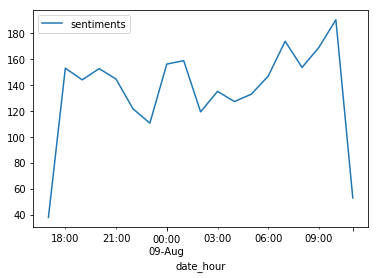

In [44]:
tweet_groupbyhr.plot(x='date_hour',y='sentiments')

In [45]:
tweet_groupbyhr.tail()

,date_hour,sentiments
14,2019-08-09 07:00:00,173.527751
15,2019-08-09 08:00:00,153.365041
16,2019-08-09 09:00:00,168.876230
17,2019-08-09 10:00:00,190.120737
18,2019-08-09 11:00:00,52.807630


In [50]:
# need to load btc data for same time period and compare the plots

In [ ]:
# plot bubble plot with size as sentiment.

In [71]:
import seaborn as sns; #sns.set()

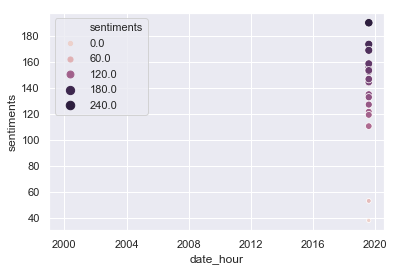

In [72]:
ax = sns.scatterplot(x="date_hour", y="sentiments",
                      hue="sentiments", size="sentiments",
                      data=tweet_grouopbyhr)
#set(xlim=(0,15),ylim=(0,100))



In [63]:
tweet_grouopbyhr

,date_hour,sentiments
0,2019-08-08 17:00:00,37.762309
1,2019-08-08 18:00:00,152.784088
2,2019-08-08 19:00:00,143.793094
3,2019-08-08 20:00:00,152.453095
4,2019-08-08 21:00:00,144.383095
5,2019-08-08 22:00:00,121.485808
6,2019-08-08 23:00:00,110.438698
7,2019-08-09 00:00:00,155.940498
8,2019-08-09 01:00:00,158.571823
9,2019-08-09 02:00:00,119.134267
